In [1]:
# import modin.config as cfg
# cfg.StorageFormat.put('hdk')
# import modin.pandas as pd

import pandas as pd

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import os
import daal4py as d4p
import time
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression

intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

read csv took: 39.72 s


<AxesSubplot:>

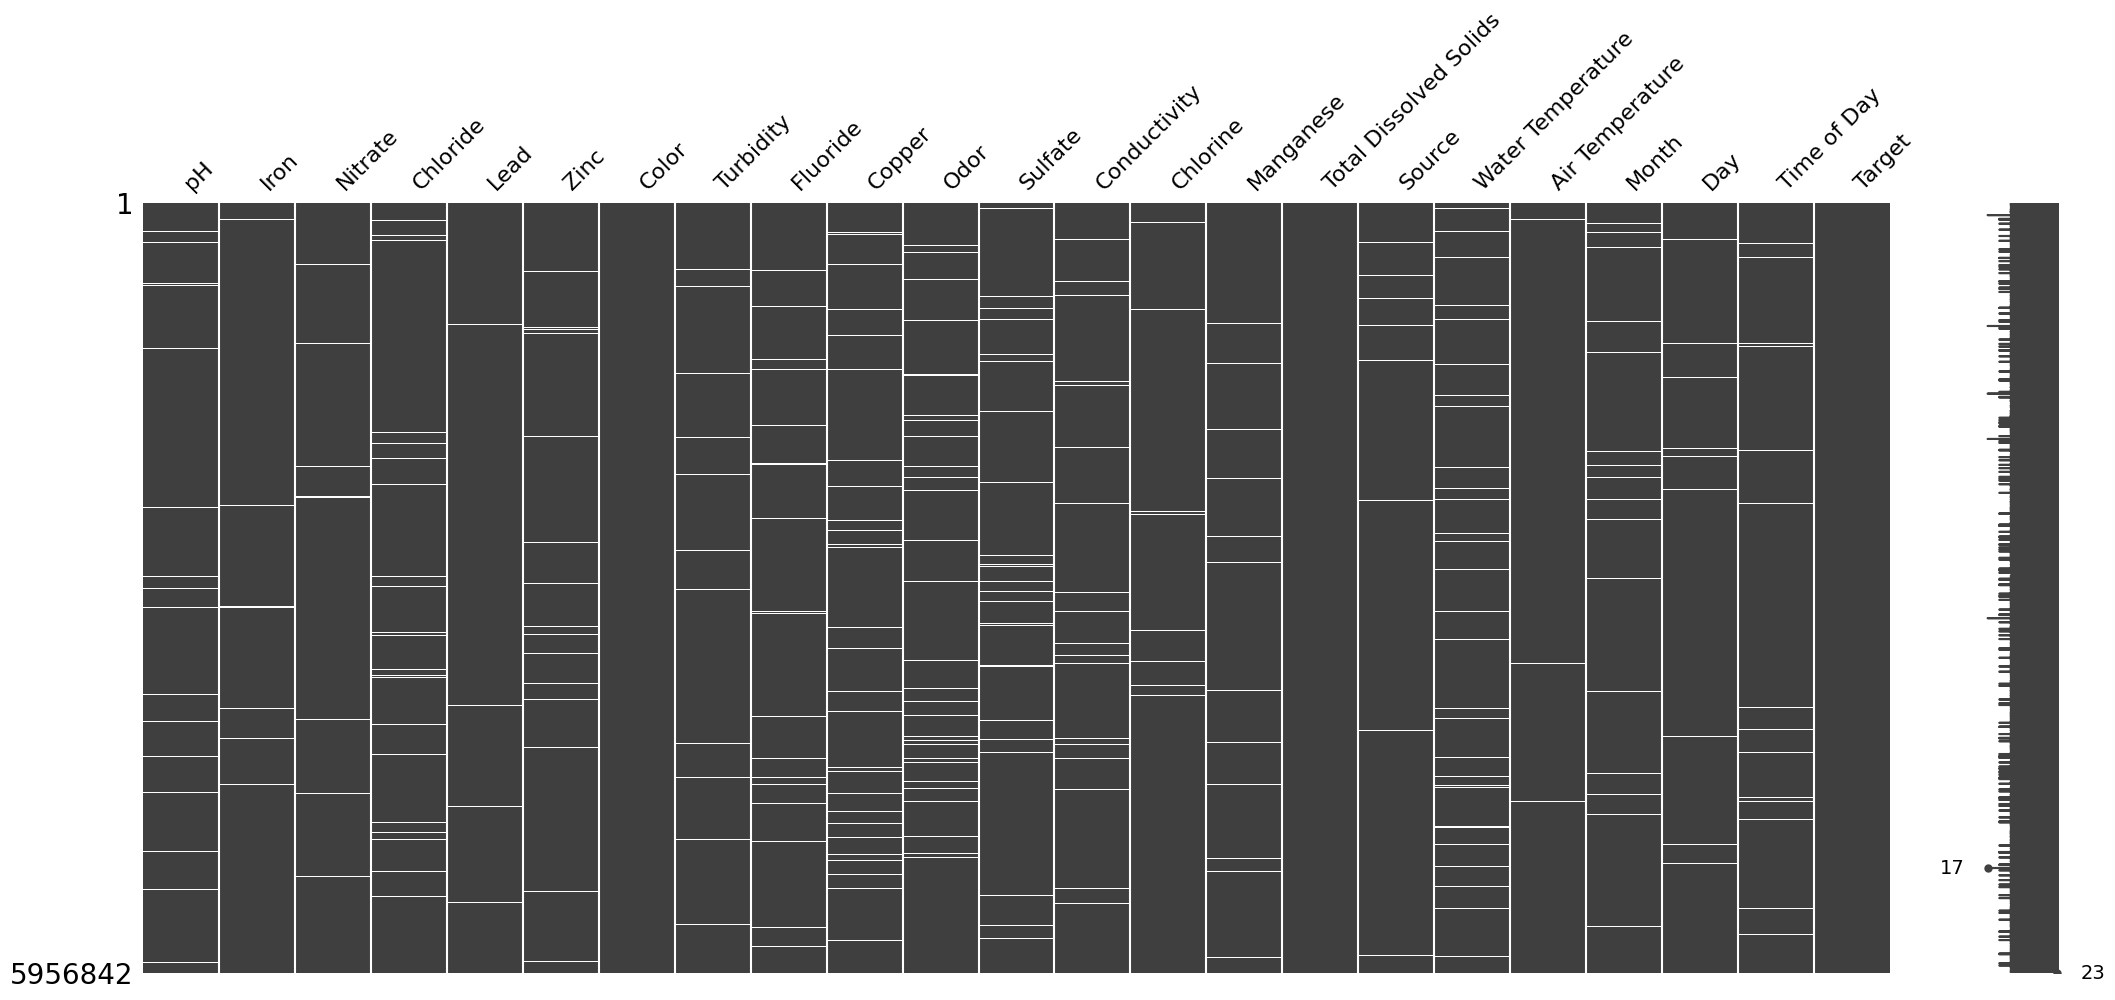

In [4]:
start_read = time.time()
# data = pd.read_csv("500k_dataset.csv")
data = pd.read_csv("dataset.csv")
print("read csv took: {:.2f} s".format(time.time() - start_read))

data.drop(['Index'], inplace=True, axis=1)

# display missing columns
msno.matrix(data)

handle missing value took: 6.44 s


<AxesSubplot:>

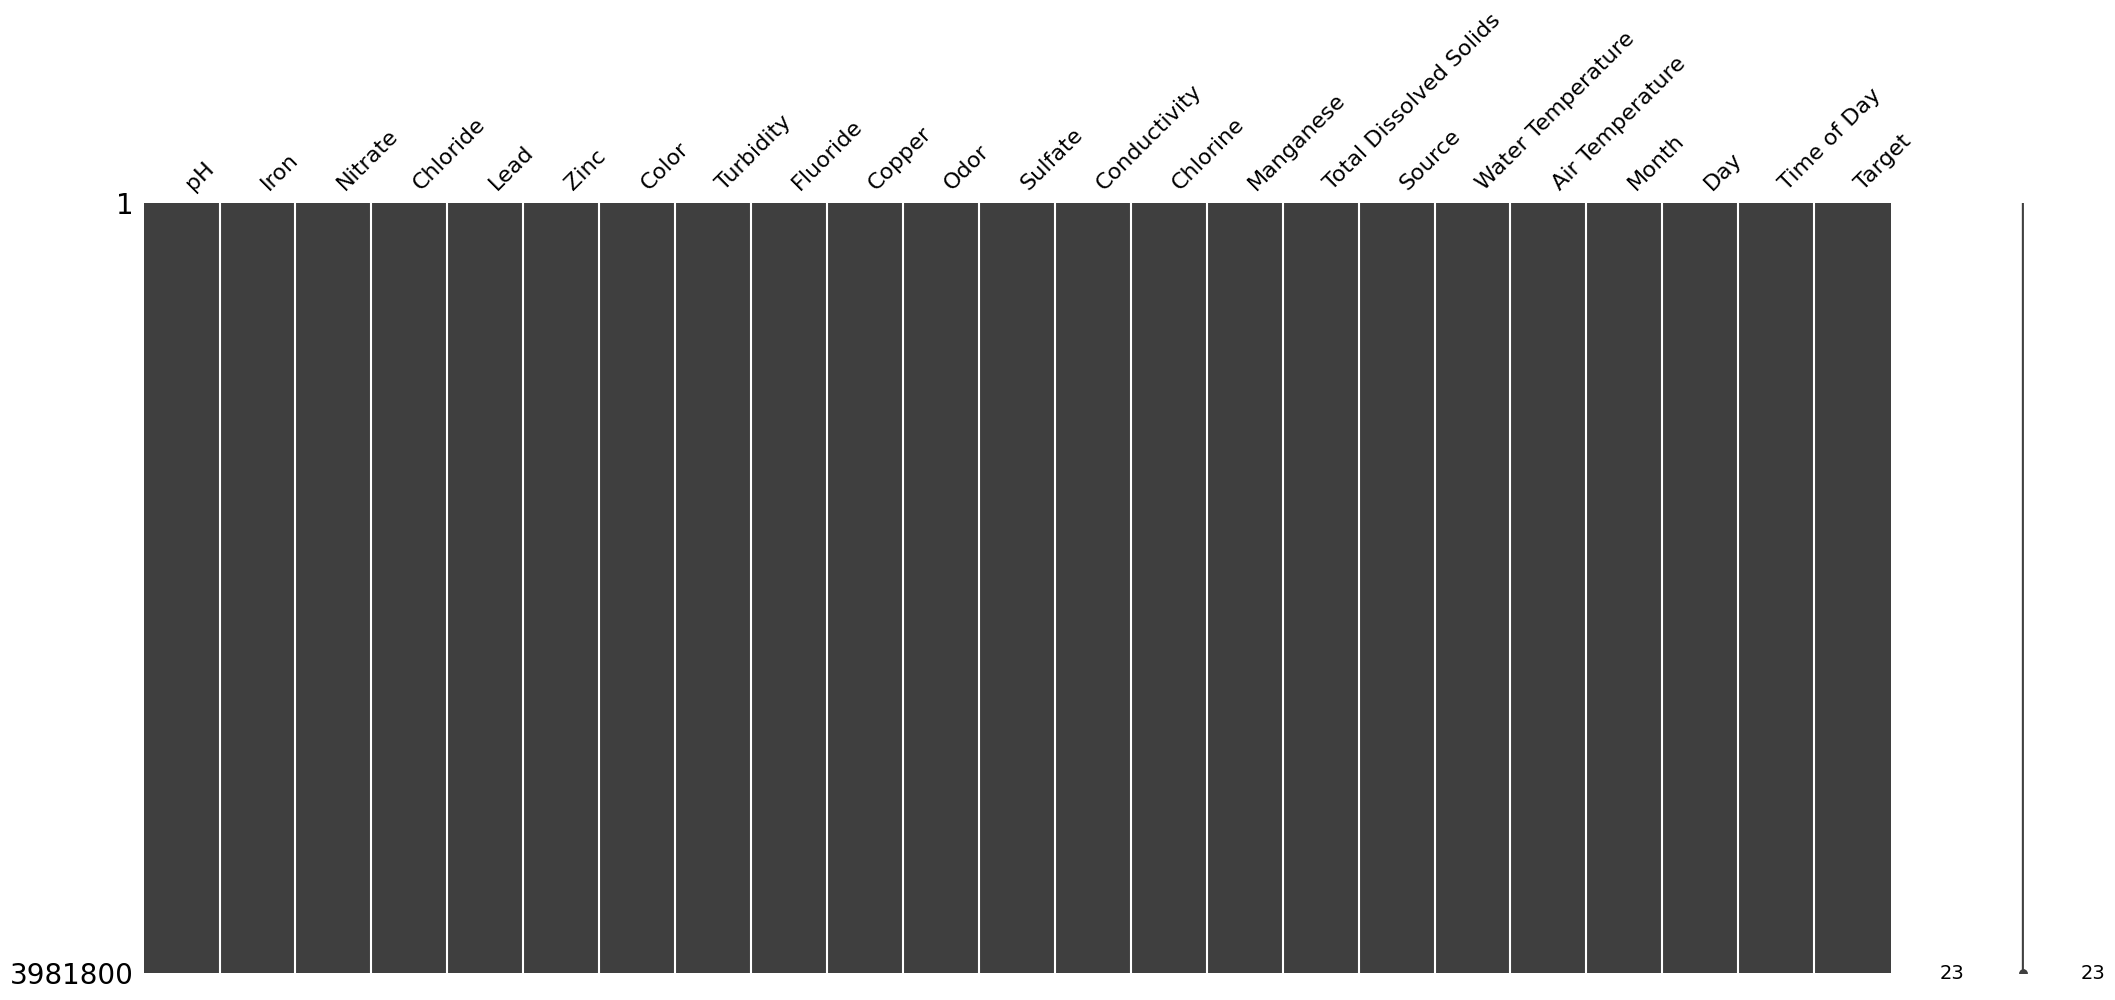

In [5]:
# handle missing values
start = time.time()

# cat_imputer = SimpleImputer(strategy='most_frequent')
# # num_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=5, random_state=0, n_jobs=-1), max_iter=5)
# num_imputer = KNNImputer(n_neighbors=2)

# cat_cols = data.select_dtypes(include=['object']).columns
# num_cols = data.select_dtypes(exclude=['object']).columns

# data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])
# # data[num_cols] = num_imputer.fit_transform(data[num_cols])
# for col in num_cols:
#     data[col] = data[col].interpolate(method='linear')

data.dropna(subset=data.columns, inplace=True)

print("handle missing value took: {:.2f} s".format(time.time() - start))

# display missing columns
msno.matrix(data)

In [6]:
# transform `Month` to number
month_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
data['Month'] = data['Month'].map(month_dict)

color_dict = {
    'Colorless': 0,
    'Near Colorless': 1,
    'Faint Yellow': 2,
    'Light Yellow': 3,
    'Yellow': 4
}
data['Color'] = data['Color'].map(color_dict)

# convert air temperature from °F to°C
data['Air Temperature'] = (data['Air Temperature'] - 32) * 5/9

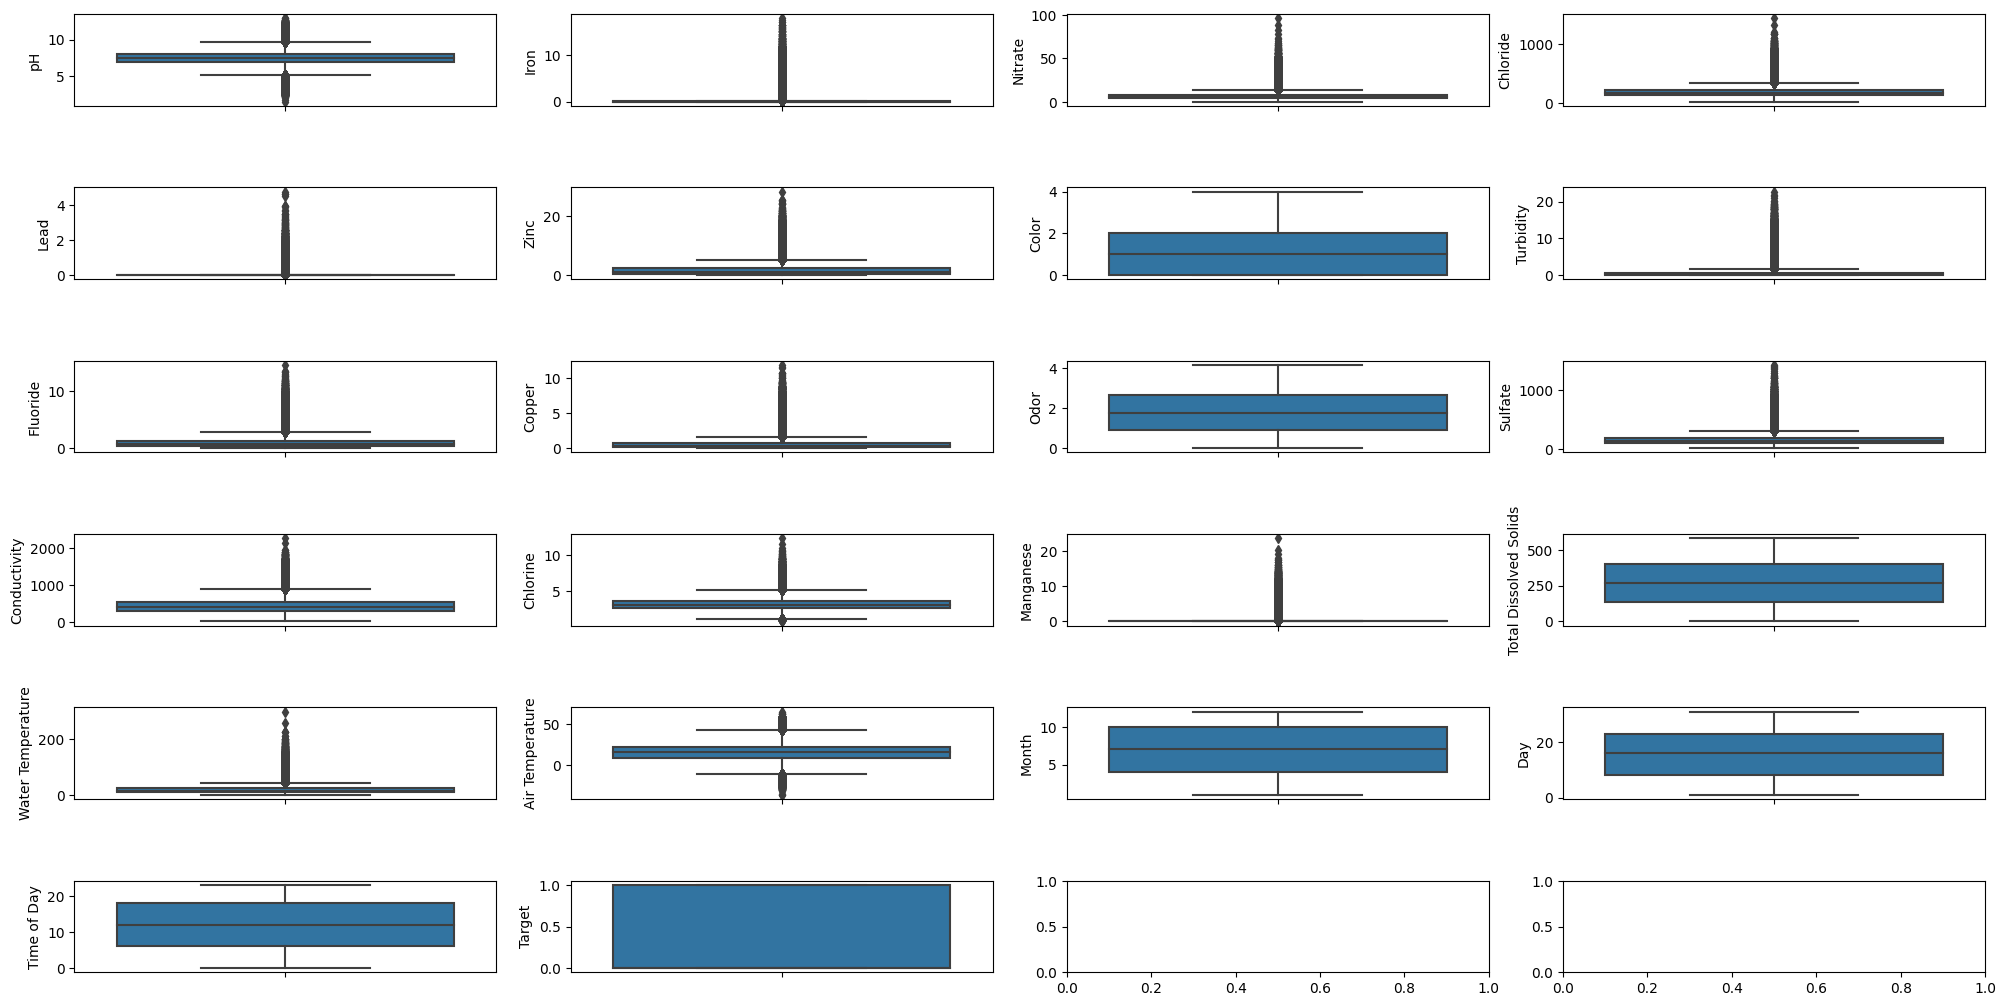

In [7]:
# Visualizing dataset and also checking for outliers 

fig, ax = plt.subplots(ncols = 4, nrows = 6, figsize = (20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    if data[col].dtype == 'object':
        continue
    sns.boxplot(y=col, data=data, ax=ax[index])
    index += 1
plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=5.0)

In [8]:
def display_stats():
    
    """
    Function to display descriptive statistics of numerical variables,
    includes skewness & kurtosis.   
    """
    
    df = data.describe()
    skewness = pd.DataFrame(data.skew(numeric_only=True), columns=['skewness']).T
    kurtosis = pd.DataFrame(data.kurt(numeric_only=True), columns=['kurtosis']).T
    df = pd.concat([df, skewness, kurtosis], axis=0)
    display(df.style.format('{:,.3f}').background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu'))

display_stats()

In [9]:
# handle outliers
start = time.time()

handle_upper_cols = ['Iron', 'Zinc', 'Turbidity', 'Fluoride', 'Copper', 'Manganese', 'Nitrate',
                     'Chloride','Sulfate','Chlorine','Water Temperature','Air Temperature', 'Odor', 'Conductivity']
handle_lower_cols = ['Nitrate','Chloride', 'Sulfate','Chlorine', 'Air Temperature', 'Odor', 'Conductivity']

for col in data.columns:
    if data[col].dtype == 'object':
        continue
    lower, upper = np.percentile(data[col], [1, 99])
    if col in handle_upper_cols:
        data.loc[data[col] > upper, col] = upper
    if col in handle_lower_cols:
        data.loc[data[col] < lower, col] = lower

print("handle outliers took: {:.2f} s".format(time.time() - start))

handle outliers took: 1.98 s


In [10]:
mapping = {}
labels_dict = {
#     'Odor': ['No Odor', 'Slight Odor', 'Noticeable Odor', 'Strong Odor'],
#     'Conductivity': ['Low', 'Medium', 'High'],
    'pH': ['Acidic', 'Neutral', 'Alkaline'],
    'Air Temperature': ['Cold', 'Moderate', 'Hot'],
    'Water Temperature': ['Cold', 'Cool', 'Moderate', 'Hot'],
    'Month': ['Q1', 'Q2', 'Q3', 'Q4'],
    'Day': ['Beginning', 'Middle', 'End'],
    'Time of Day': ['Night', 'Morning', 'Afternoon', 'Evening'],
}

# discretize features
data['Month'] = pd.cut(data['Month'], bins=[0, 3, 6, 9, 12], labels=labels_dict['Month'], include_lowest=True)
data['Day'] = pd.cut(data['Day'], bins=[0, 10, 20, 31], labels=labels_dict['Day'], include_lowest=True)
data['Time of Day'] = pd.cut(data['Time of Day'], bins=[0, 6, 12, 18, 24], labels=labels_dict['Time of Day'], include_lowest=True)
data['Air Temperature'] = pd.cut(data['Air Temperature'], bins=[-10, 10, 25, np.inf], labels=labels_dict['Air Temperature'], include_lowest=True)
data['Water Temperature'] = pd.cut(data['Water Temperature'], bins=[0, 10, 20, 30, np.inf], labels=labels_dict['Water Temperature'], include_lowest=True)

data['pH'] = pd.cut(data['pH'], bins=[0, 6.5, 8.5, 14], labels=labels_dict['pH'], include_lowest=True)
# data['Odor'] = pd.cut(data['Odor'], bins=[-np.inf, 1, 2, 3, np.inf], labels=labels_dict['Odor'])
# data['Conductivity'] = pd.cut(data['Conductivity'], bins=[-np.inf, 300, 600, np.inf], labels=labels_dict['Conductivity'])

# transform labels to numerics
for col in ['pH', 'Air Temperature','Water Temperature', 'Month', 'Day', 'Time of Day', 'Source']:
    data = pd.get_dummies(data, columns=[col], drop_first=False)
# for _, column in enumerate([]):
#     if column in labels_dict:
#         labels = labels_dict[column]
#         category = pd.Categorical(data[column], categories=labels, ordered=True)
#         data[column] = category.codes
#         mapping[column] = labels

In [11]:
# drop duplicated rows
data = data.drop_duplicates()

# check data
missing = data.isna().sum().sum()
duplicates = data.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

display(data.head())


There are 0 missing values in the data.
There are 0 duplicate records in the data.


Iron   Nitrate    Chloride           Lead      Zinc  Color  \
1  8.053827e-05  3.734167  227.029851   7.849262e-94  1.245317      2   
2  2.010586e-02  3.816994  230.995630   5.286616e-76  0.528280      3   
4  2.167128e-03  9.925788  186.540872  4.171069e-132  3.807511      3   
7  6.107130e-09  9.261676  182.242341  4.399852e-224  0.416478      0   
9  3.019038e-03  3.620641  157.043934  6.459725e-148  0.112994      0   

   Turbidity  Fluoride    Copper      Odor  ...  Time of Day_Afternoon  \
1   0.019007  0.622874  0.437835  1.686049  ...                      1   
2   0.319956  0.423423  0.431588  3.414619  ...                      0   
4   0.004867  0.222912  0.616574  0.795310  ...                      0   
7   0.047803  1.016196  0.298093  3.144199  ...                      0   
9   0.050613  0.842107  0.391602  2.713379  ...                      0   

   Time of Day_Evening  Source_Aquifer  Source_Ground  Source_Lake  \
1                    0               0              0            1   
2                    0               0              0            0   
4                    0               0              0            0   
7                    0               0              0            0   
9                    0               0              0            0   

   Source_Reservoir  Source_River  Source_Spring  Source_Stream  Source_Well  
1                 0             0              0              0            0  
2                 0             1              0              0            0  
4                 0             0              1              0            0  
7                 0             1              0              0            0  
9                 0             1              0              0            0  

[5 rows x 45 columns]

In [12]:
# show target distribution
target=data['Target'].value_counts(normalize=True)
target.rename(index={1:'State 1',0:'State 0'},inplace=True)
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     text=target.index, sort=False, showlegend=False,
                     marker=dict(colors=color,line=dict(color=intel_pal,width=2.5)),
                     hovertemplate = "%{label}: <b>%{value:.2f}%</b><extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',width=700,height=450,
                  uniformtext_minsize=15, uniformtext_mode='hide')
fig.show() 

In [13]:
cat_cols,float_cols=[],['Target']
for col in data.columns:
    if data[col].value_counts().count() < 10:
        cat_cols.append(col)
    else:
        float_cols.append(col)
        
print(cat_cols)
print(float_cols)

['Color', 'Target', 'pH_Acidic', 'pH_Neutral', 'pH_Alkaline', 'Air Temperature_Cold', 'Air Temperature_Moderate', 'Air Temperature_Hot', 'Water Temperature_Cold', 'Water Temperature_Cool', 'Water Temperature_Moderate', 'Water Temperature_Hot', 'Month_Q1', 'Month_Q2', 'Month_Q3', 'Month_Q4', 'Day_Beginning', 'Day_Middle', 'Day_End', 'Time of Day_Night', 'Time of Day_Morning', 'Time of Day_Afternoon', 'Time of Day_Evening', 'Source_Aquifer', 'Source_Ground', 'Source_Lake', 'Source_Reservoir', 'Source_River', 'Source_Spring', 'Source_Stream', 'Source_Well']
['Target', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine', 'Manganese', 'Total Dissolved Solids']


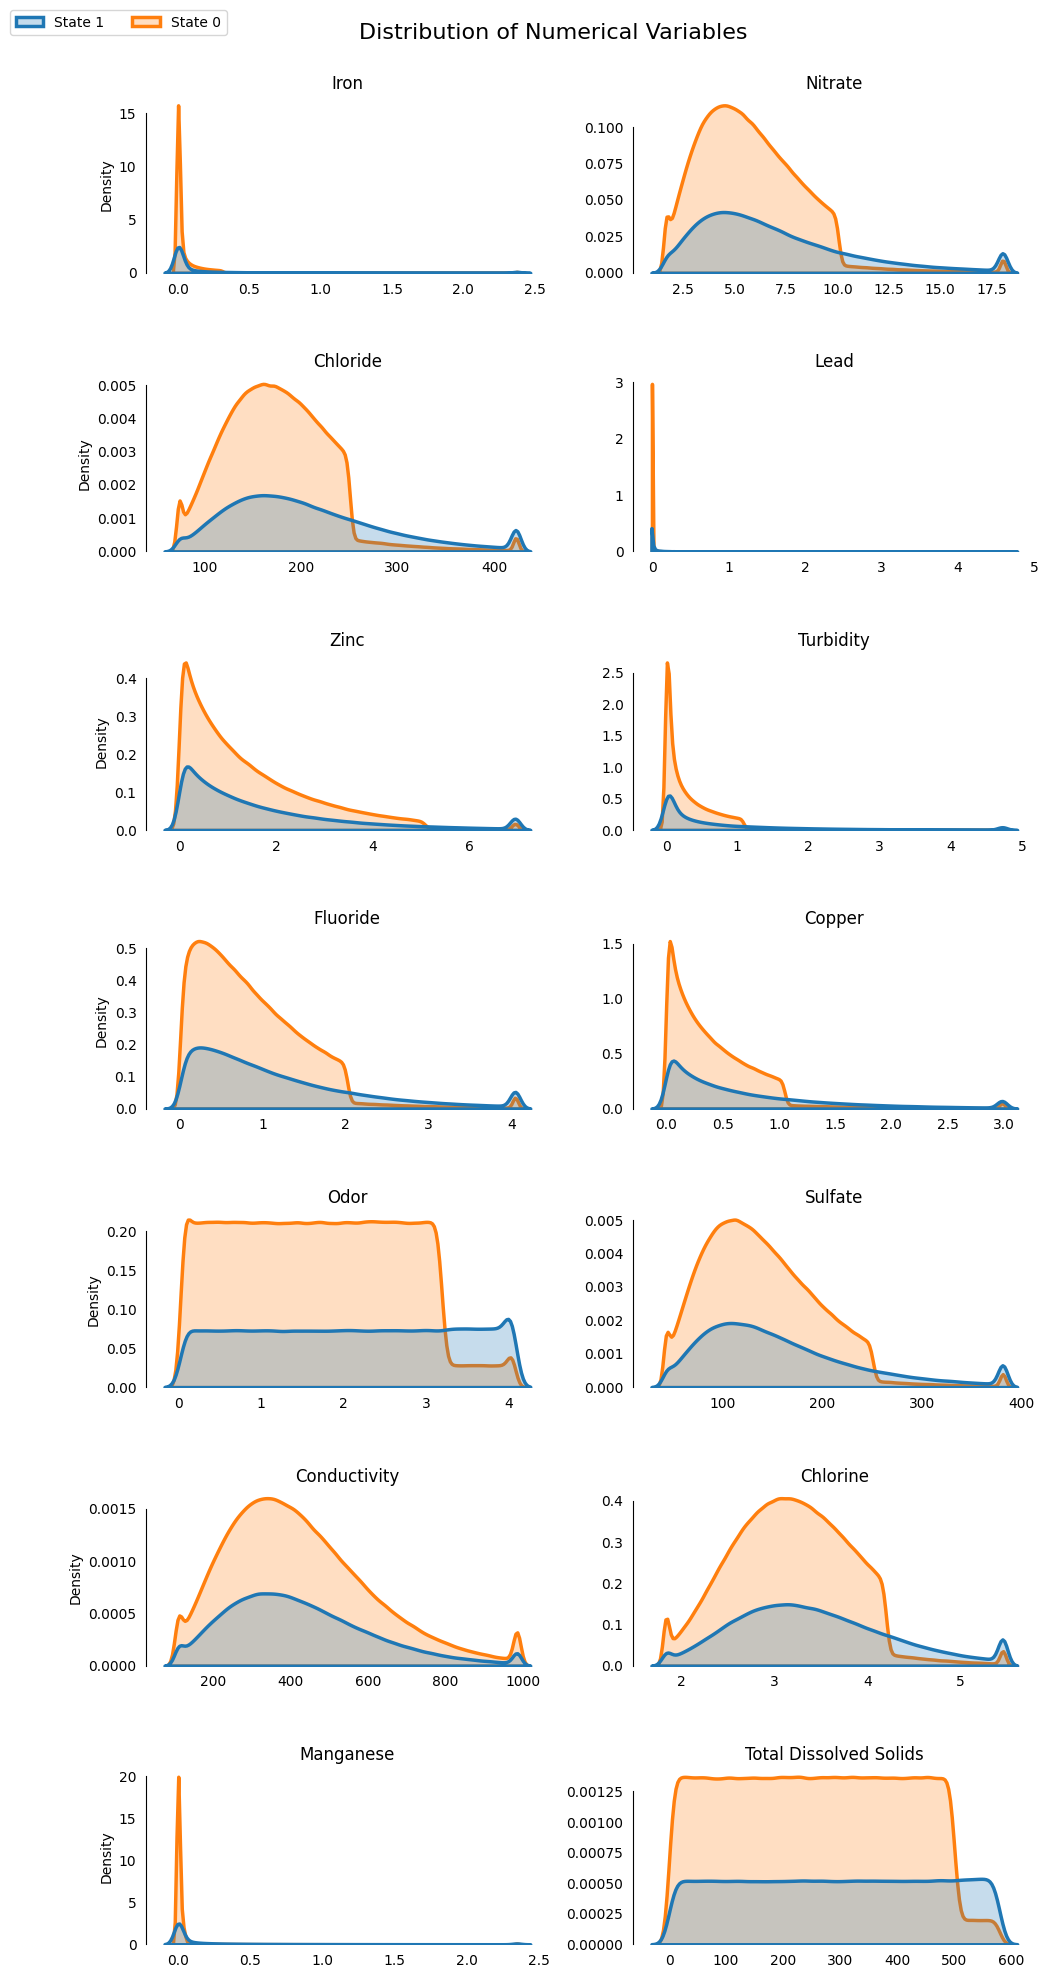

In [14]:
plot_df=data[float_cols]

fig, ax = plt.subplots(7,2, figsize=(10,20))
fig.suptitle('Distribution of Numerical Variables',fontsize=16)
row=0
col=[0,1]*7

for i, column in enumerate(plot_df.columns[1:]):
    if (i!=0)&(i%2==0):
        row+=1
    
    sns.kdeplot(
        x=column, hue='Target', hue_order=[1, 0],
        label=['State 1', 'State 0'], data=plot_df,
        fill=True, linewidth=2.5, legend=False, ax=ax[row, col[i]]
    )
    
    ax[row,col[i]].tick_params(left=False, bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%2==0 else ''))

handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['State 1','State 0'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.99))
sns.despine(bottom=True, trim=True)
plt.tight_layout()

In [15]:
fig=make_subplots(rows=7,cols=2, subplot_titles=float_cols[1:])
col=[1,2]*7
row=0
pal=sns.color_palette("GnBu",20).as_hex()[9:][::3]

for i, column in enumerate(data[float_cols].columns[1:]):
    if i%2 == 0:
        row += 1
    df = pd.concat([data[column], data['Target']], axis=1)

    df['bins'] = pd.cut(df[column], 500)
    df['mean'] = df.bins.apply(lambda x: x.mid)

    df = df.groupby('mean')[[column,'Target']].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    
    fig.add_trace(go.Scatter(x=df[column], y=df.Target, name=column,
                             marker_color=pal[i % len(pal)], showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%2 == 0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i]) 
fig.update_layout(template=temp, title='Feature Relationships with Target', hovermode="x unified",height=1700,width=1200)
fig.show()

In [16]:
def displayScatterplot(check_cols):
    check_cols_len = len(check_cols)

    plot_df=data[check_cols]
    fig, ax = plt.subplots(check_cols_len, check_cols_len, figsize=(16,18))
    fig.suptitle('Scatterplot Matrix of Numeric Variables\nLog-Transformed',fontsize=16)
    for i, col in enumerate(check_cols):
        for j, iter_col in enumerate(check_cols):
            ax[i,j].hexbin(x=iter_col, y=col, data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
            ax[i,j].set(xlabel=iter_col, ylabel=(col if j % check_cols_len == 0 else ''))
            ax[i,j].text(plot_df[iter_col].median(), plot_df[col].max(), 
                         'Correlation: {:.4f}'.format(plot_df[[col,iter_col]].corr().iloc[1,0]), 
                       ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
            ax[i,j].tick_params(left=False,bottom=False)    

    sns.despine()
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

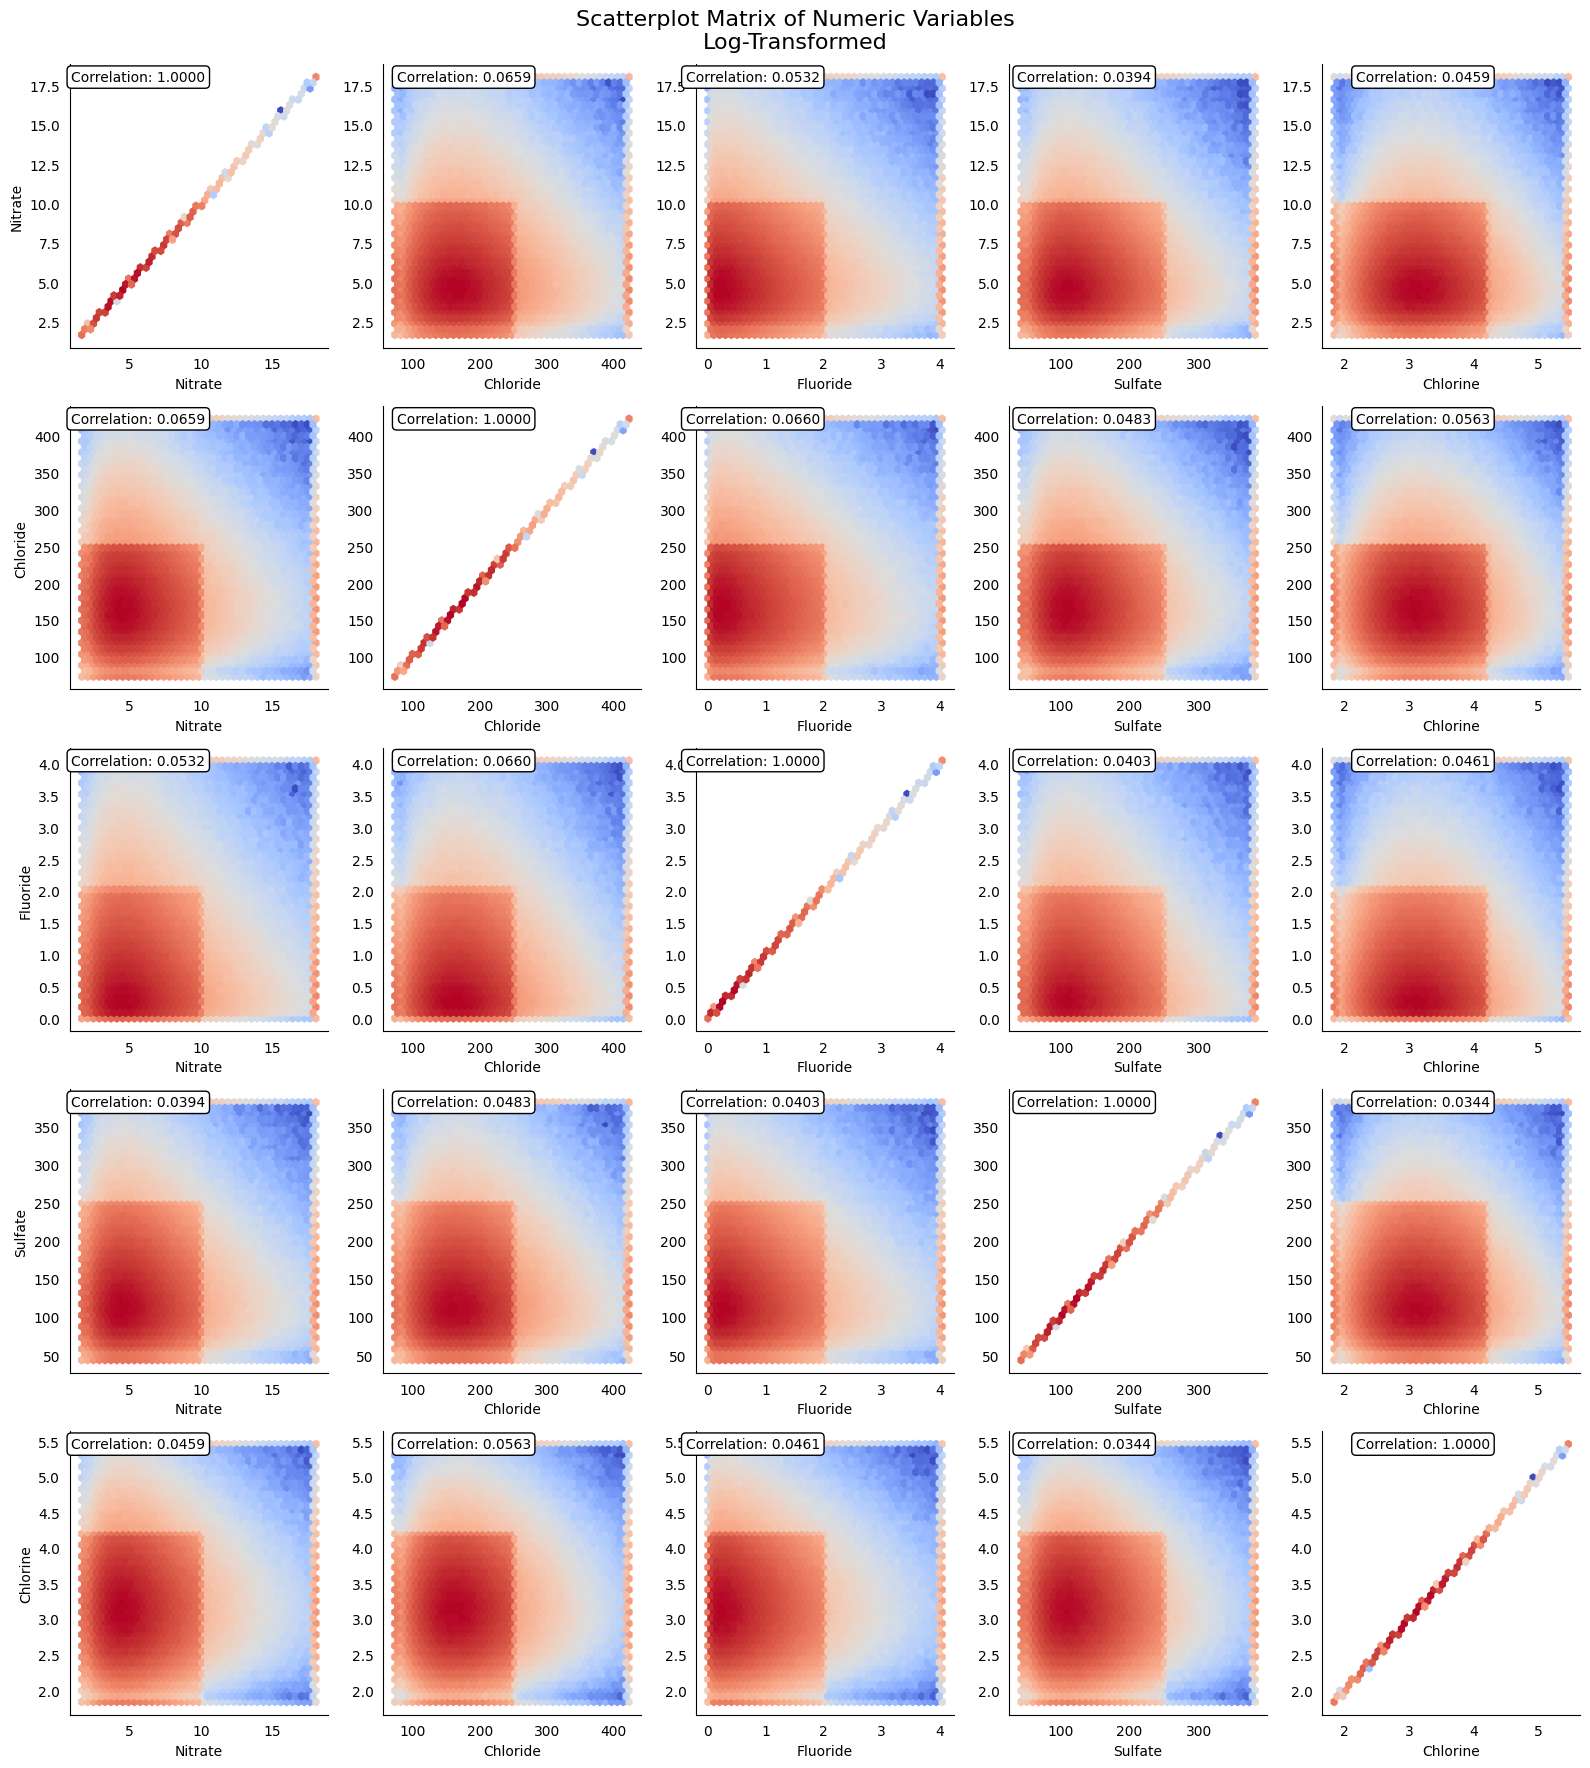

In [17]:
# display for chemicals
displayScatterplot(['Nitrate', 'Chloride', 'Fluoride', 'Sulfate', 'Chlorine'])

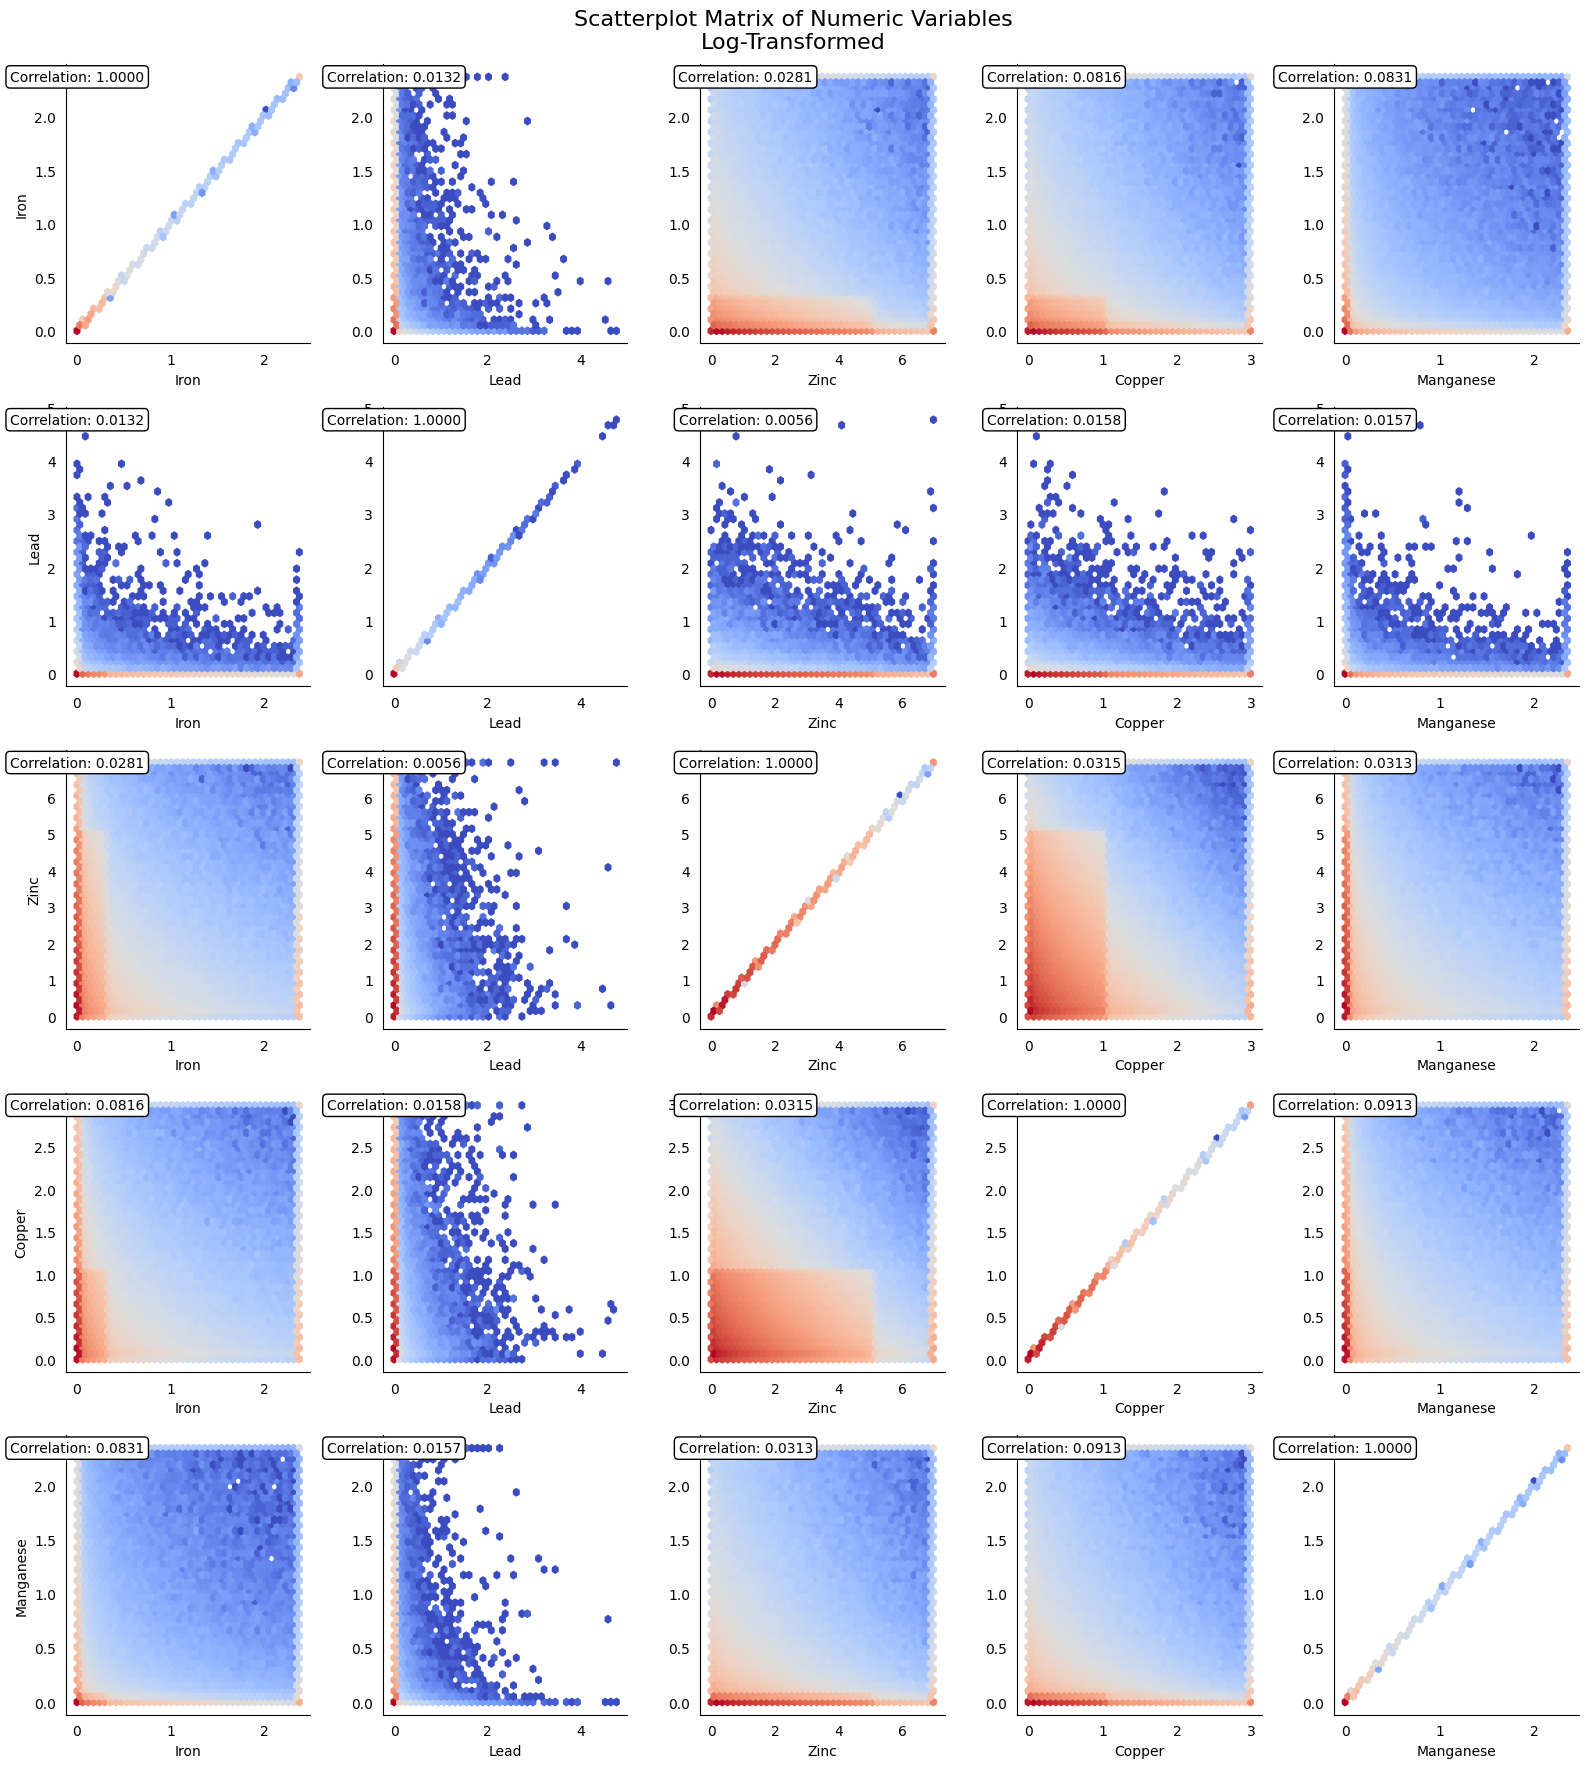

In [18]:
# display for mentals
displayScatterplot(['Iron', 'Lead', 'Zinc', 'Copper', 'Manganese'])

In [19]:
fig = make_subplots(rows=8, cols=4, subplot_titles=[c for c in cat_cols if c!='Target'])
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.6)) for i in intel_pal]
row=0
c=[1,2,3,4]*8
for i, col in enumerate(c for c in cat_cols if c!='Target'):
    if i%4==0:
        row+=1

    df=data.groupby(col)['Target'].value_counts().rename('count').reset_index()
    x_1 = pd.Series(dtype=int)
    x_0 = pd.Series(dtype=int)
    if col in mapping:
        mapping_series = pd.Series(mapping[col])
        x_1 = mapping_series[df[df.Target==1][col]]
        x_0 = mapping_series[df[df.Target==0][col]]
    else:
        x_1 = df[df.Target==1][col]
        x_0 = df[df.Target==0][col]

    fig.add_trace(go.Bar(x=x_1,
                         y=df[df.Target==1]['count'],width=.35,
                         marker_color=rgb[1], marker_line=dict(color=intel_pal[1],width=2.5), 
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 1', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=x_0,
                         y=df[df.Target==0]['count'],width=.35,
                         marker_color=rgb[0], marker_line=dict(color=intel_pal[0],width=2.5),
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 0', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%4==0:
        fig.update_yaxes(title='Frequency',row=row,col=c[i])
fig.update_layout(title="Distributions of Categorical Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.025,xanchor="right",x=.2),
                  barmode='group',height=1400,width=1200)
fig.show()

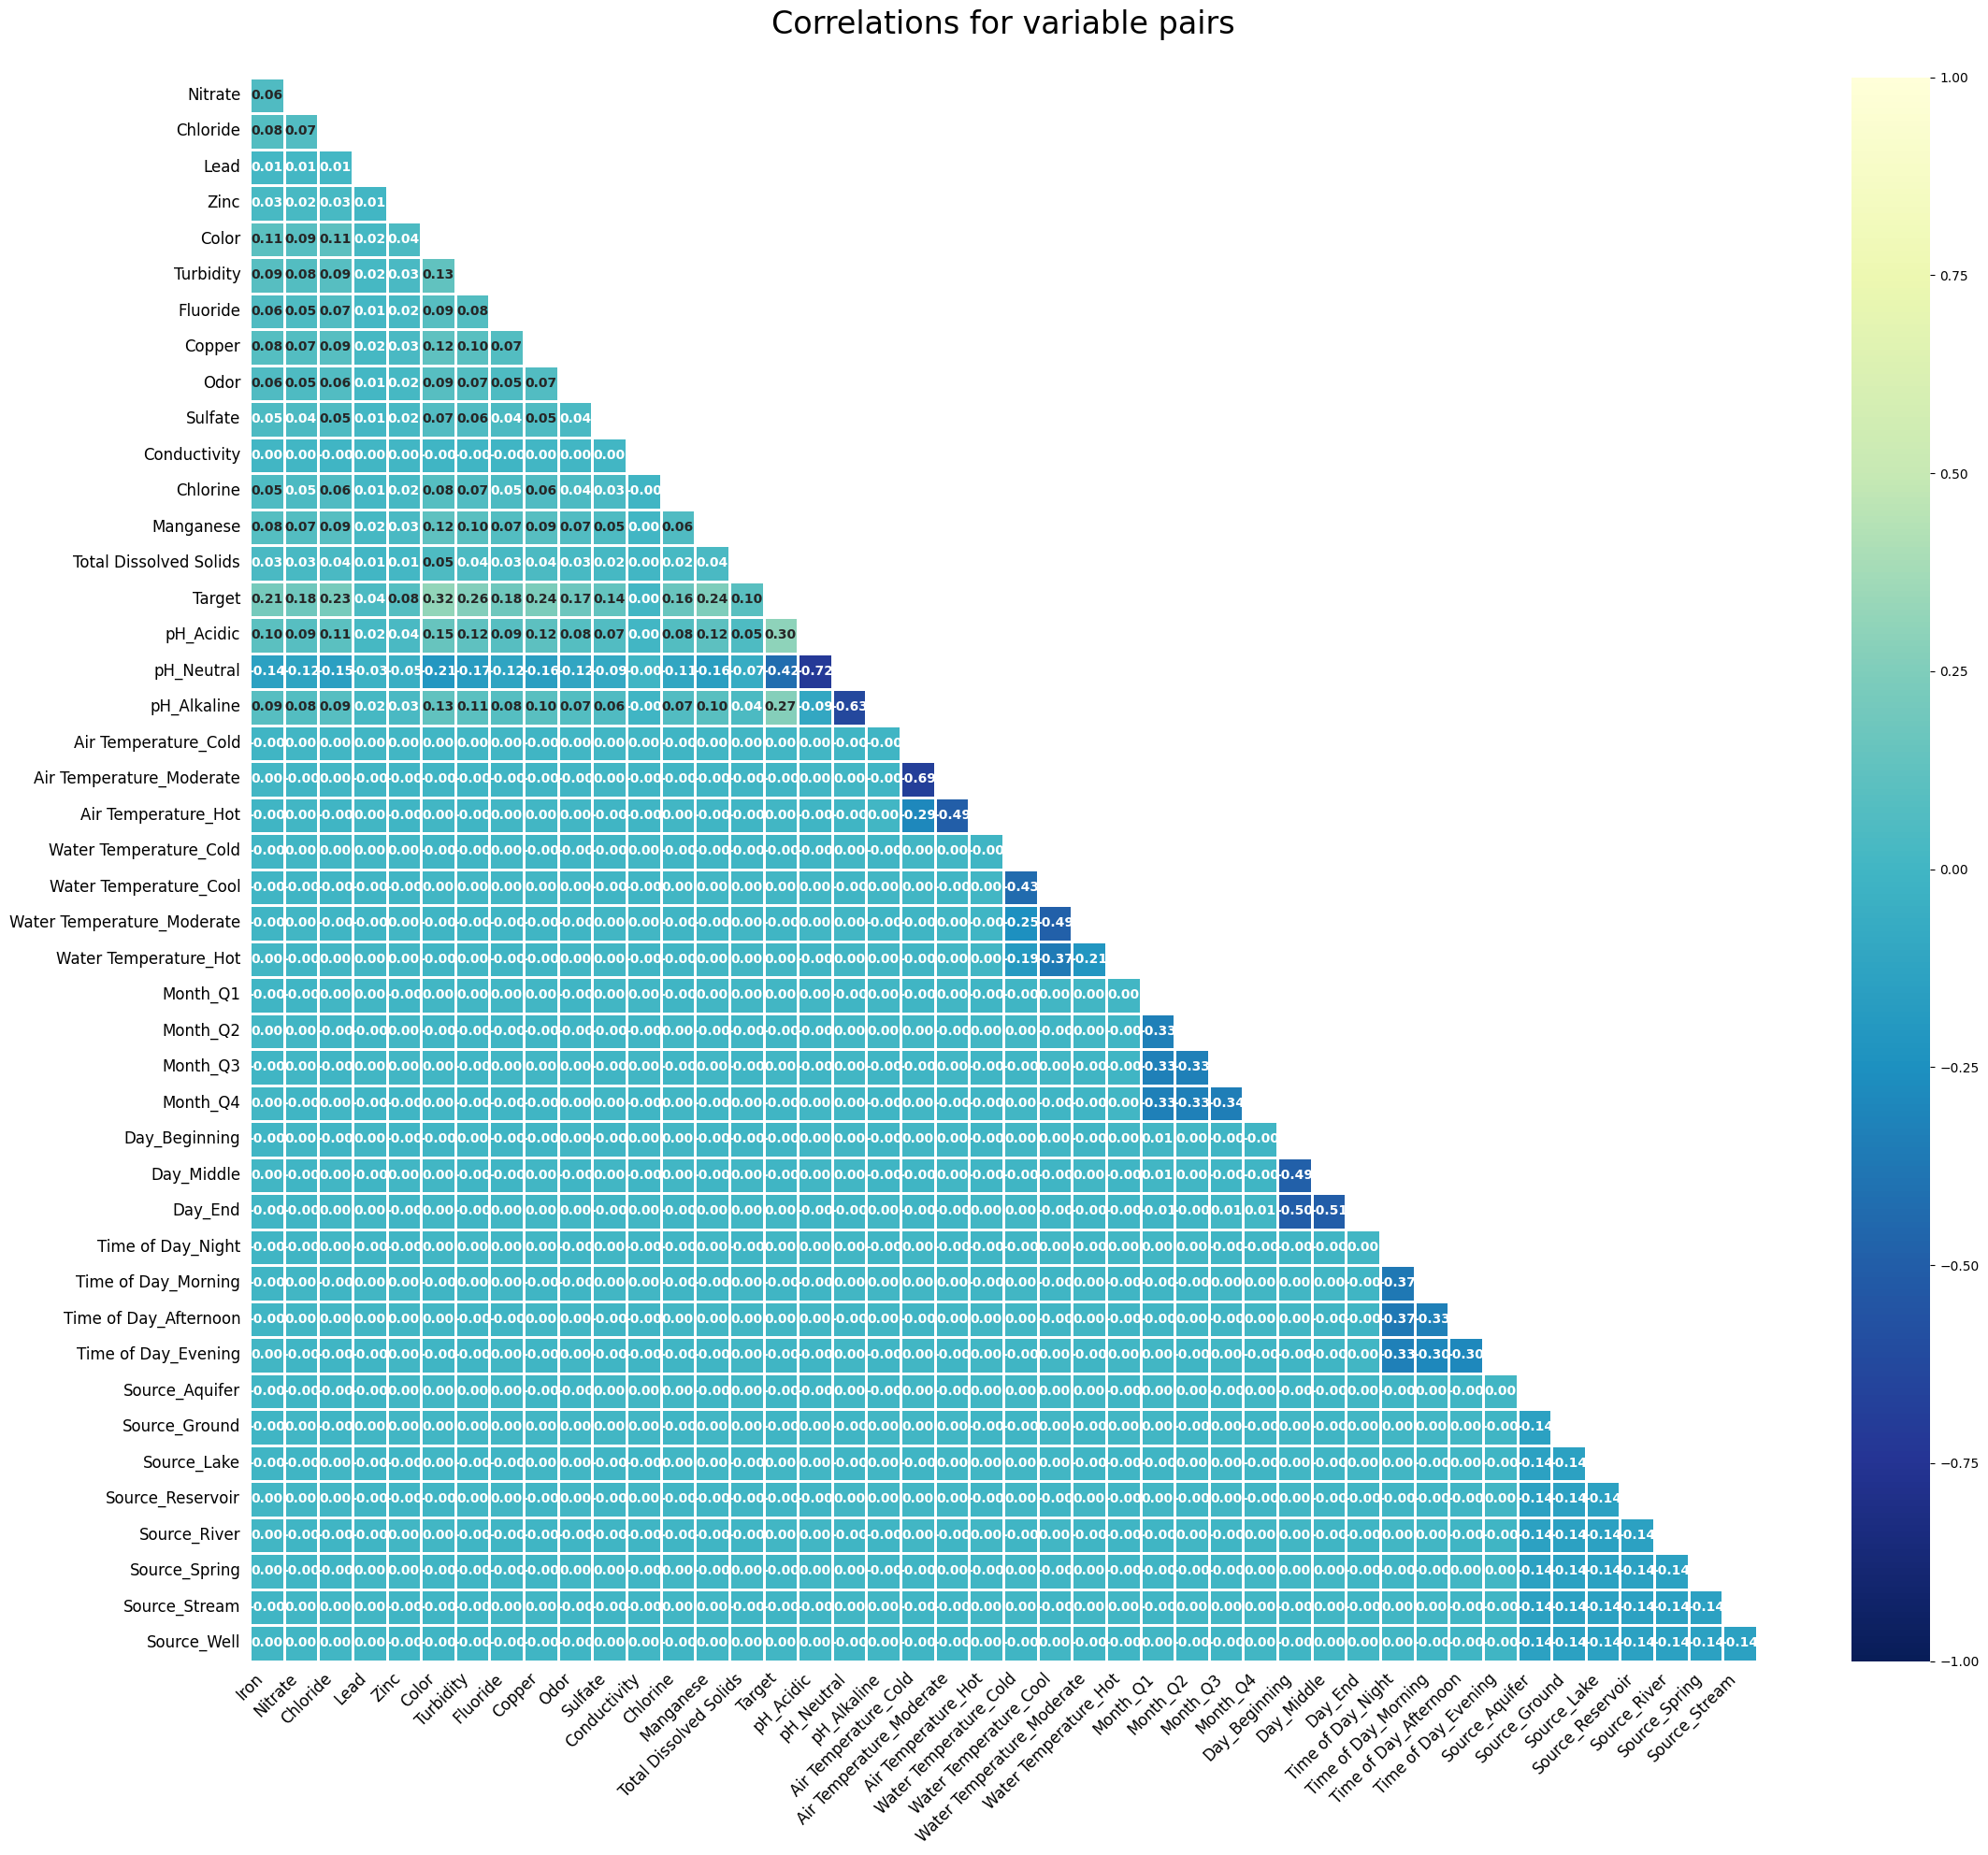

In [20]:
def plot_corr(corr):
    """
    Function to plot bottom left triangle of correlation matrix
    """
    mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
    corr=corr.iloc[1:,:-1].copy()
    fig, ax = plt.subplots(figsize=(26,22))   
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
                cmap='YlGnBu_r',lw=2, annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=True)
    ax.tick_params(left=False,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
    plt.title('Correlations for variable pairs\n', fontsize=24)
    plt.show()
    
def plot_target_corr(corr, target_col): 
    """
    Function to plot a bar chart of correlations between target and features, sorted in descending order
    """
    corr=corr[target_col].sort_values(ascending=False)[1:]
    pal=sns.color_palette("RdYlBu",37).as_hex()
    pal=[j for i,j in enumerate(pal) if i not in (17,18)]
    rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
    
    fig=go.Figure()
    fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                         marker_line=dict(color=pal,width=2),
                         hovertemplate='%{x} correlation with Target = %{y}',
                         showlegend=False, name=''))
    fig.update_layout(template=temp, title='Feature Correlations with Target', 
                      yaxis_title='Correlation', margin=dict(b=160), xaxis_tickangle=45)
    fig.show()
    
corr=data.corr()
plot_corr(corr=corr)
plot_target_corr(corr=corr, target_col='Target')